In [109]:
import csv
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import igraph
from collections import Counter
from datetime import datetime
import holidays
import dateutil.parser

In [3]:
p_i_dict = {}
directory = 'finance_data\data'

if os.path.exists("p_i_dict.pickle"):
    with open('p_i_dict.pickle', 'rb') as pickle_file:
        p_i_dict = pickle.load(pickle_file)

if p_i_dict == {}:
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            with open(directory + '\\' + filename, newline='') as csvfile:
                company_stock_data = csv.reader(csvfile, delimiter=',')
                p = []

                for i, row in enumerate(company_stock_data):
                    if i != 0:
                        p.append(row[4])

            p_i_dict[filename[:-4]] = np.array(p).astype('float64')
    pickle.dump( p_i_dict, open( "p_i_dict.pickle", "wb" ) )

In [4]:
def calc_q_r(p):
    prev_close_val = 0
    r = []
    for i, close_val in enumerate(p):
        if i != 0:
            r.append(np.log(1+(close_val-prev_close_val)/prev_close_val))
        prev_close_val = close_val
    return r

In [5]:
def vec_mult(a,b):
    a_len = len(a)
    b_len = len(b)
    if a_len > b_len:
        return np.multiply(a[:b_len-a_len],b)
    elif a_len < b_len:
        return np.multiply(a,b[:a_len-b_len])
    else:
        return np.multiply(a,b)

In [6]:
def calc_p_i_j(r_i):
    r_j = r_i
    r_i_len = len(r_i)
    p_i_j = np.zeros((r_i_len,r_i_len))
    
    for i, r1 in enumerate(r_i):
        r1_avg = np.mean(r1)
        for j, r2 in enumerate(r_j):
            r2_avg = np.mean(r2)
            top_term = np.mean(vec_mult(r1,r2)) - r1_avg*r2_avg
            bot_term = np.sqrt((np.mean(np.square(r1))-r1_avg**2)*(np.mean(np.square(r2))-r2_avg**2))
            p_i_j[i][j] = top_term / bot_term
            
    return p_i_j

In [7]:
def get_sectors():
    with open('finance_data/Name_sector.csv') as csvfile:
        sector_data = csv.reader(csvfile, delimiter=',')
        sector_list = []
        sector_dict = {}
        dict_count = 0

        for i, row in enumerate(sector_data):
            if i != 0:
                sector_name = row[1]
                if sector_name in sector_dict:
                    sector_list.append(sector_dict[sector_name])
                else:
                    sector_dict[sector_name] = dict_count
                    dict_count += 1
                    sector_list.append(sector_dict[sector_name])

    return sector_list

In [8]:
#q1
r_i = []

for name, p in p_i_dict.items():
    r_i.append(calc_q_r(p))

p_i_j = calc_p_i_j(r_i)
print(p_i_j)

[[1.         0.29248048 0.1939183  ... 0.39781719 0.41576816 0.34266478]
 [0.29248048 1.         0.25874995 ... 0.29951503 0.3597007  0.28154192]
 [0.1939183  0.25874995 1.         ... 0.28297235 0.30704598 0.22116485]
 ...
 [0.39781719 0.29951503 0.28297235 ... 1.         0.34494546 0.36782199]
 [0.41576816 0.3597007  0.30704598 ... 0.34494546 1.         0.3026061 ]
 [0.34266478 0.28154192 0.22116485 ... 0.36782199 0.3026061  1.        ]]


In [9]:
w_i_j = np.sqrt(2*(1-p_i_j))
print(w_i_j)

[[0.         1.18955414 1.26970997 ... 1.09743593 1.08095498 1.14659079]
 [1.18955414 0.         1.21757961 ... 1.18362576 1.13163537 1.19871437]
 [1.26970997 1.21757961 0.         ... 1.19752048 1.17724595 1.24806662]
 ...
 [1.09743593 1.18362576 1.19752048 ... 0.         1.14459996 1.12443587]
 [1.08095498 1.13163537 1.17724595 ... 1.14459996 0.         1.18101135]
 [1.14659079 1.19871437 1.24806662 ... 1.12443587 1.18101135 0.        ]]


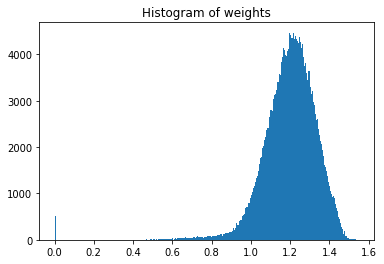

In [10]:
#q2
plt.hist(w_i_j.flatten(), bins='auto')
plt.title("Histogram of weights")
plt.show()

In [91]:
#q3
g = igraph.Graph.Weighted_Adjacency(list(w_i_j))
MST_g = g.spanning_tree(weights=g.es["weight"])
sector_MST_g = igraph.VertexClustering(MST_g,membership=get_sectors())

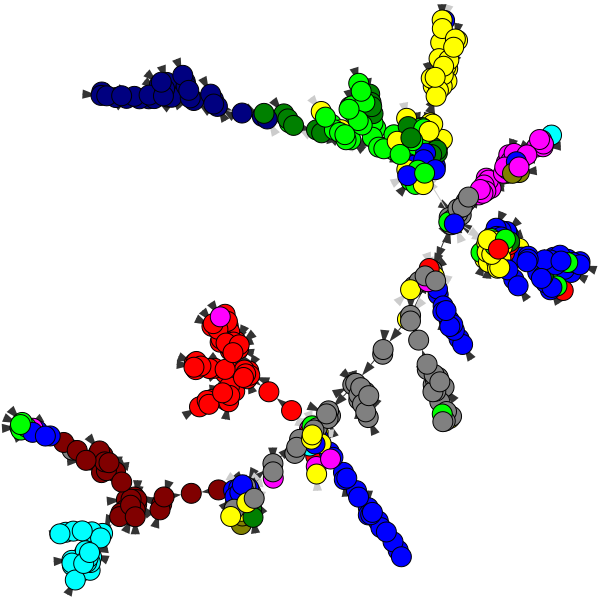

In [98]:
igraph.plot(sector_MST_g)

In [94]:
#q4

In [89]:
def calc_N_Q_S_i(g,vertex,sectors_list):
    neighbors = g.neighbors(vertex)
    
    N_i = len(neighbors)
    
    Q_i = sum(1 for i in neighbors if sectors_list[i] == sectors_list[vertex])

    counter_dict = Counter(sectors_list)
    S_i = counter_dict[sectors_list[vertex]]
    
    return N_i, Q_i, S_i

In [90]:
V_count = MST_g.vcount()
sectors_list = get_sectors()

alpha_1 = 0
alpha_2 = 0

for vertex in range(V_count):
    N_i, Q_i, S_i = calc_N_Q_S_i(MST_g,vertex,sectors_list)
    alpha_1 += Q_i / N_i
    alpha_2 += S_i / V_count

alpha_1 /= V_count
alpha_2 /= V_count

print(alpha_1)
print(alpha_2)

0.8088939768319879
0.11456523870208775


In [116]:
#q5
p_i_dict = {}
directory = 'finance_data\data'
us_holidays = holidays.US()

if os.path.exists("p_i_mondays_dict.pickle"):
    with open('p_i_mondays_dict.pickle', 'rb') as pickle_file:
        p_i_dict = pickle.load(pickle_file)

if p_i_dict == {}:
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            print(filename)
            with open(directory + '\\' + filename, newline='') as csvfile:
                company_stock_data = csv.reader(csvfile, delimiter=',')
                p = []

                for i, row in enumerate(company_stock_data):
                    if i != 0:
                        datetime_obj = dateutil.parser.parse(row[0])
                        if datetime_obj.weekday() == 0 and row[0] not in us_holidays:
                            p.append(row[4])

            p_i_dict[filename[:-4]] = np.array(p).astype('float64')
    pickle.dump( p_i_dict, open( "p_i_mondays_dict.pickle", "wb" ) )

In [117]:
r_i = []

for name, p in p_i_dict.items():
    r_i.append(calc_q_r(p))

p_i_j = calc_p_i_j(r_i)
print(p_i_j)

[[1.         0.26178276 0.18272517 ... 0.3736958  0.38793193 0.48712296]
 [0.26178276 1.         0.37887919 ... 0.2911181  0.33734748 0.3407948 ]
 [0.18272517 0.37887919 1.         ... 0.29723567 0.32245057 0.29905989]
 ...
 [0.3736958  0.2911181  0.29723567 ... 1.         0.26685815 0.57242759]
 [0.38793193 0.33734748 0.32245057 ... 0.26685815 1.         0.35385229]
 [0.48712296 0.3407948  0.29905989 ... 0.57242759 0.35385229 1.        ]]


In [118]:
w_i_j = np.sqrt(2*(1-p_i_j))
print(w_i_j)

[[0.         1.2150862  1.27849508 ... 1.11919989 1.10640686 1.01279518]
 [1.2150862  0.         1.11455893 ... 1.19069887 1.15121894 1.14822054]
 [1.27849508 1.11455893 0.         ... 1.18554994 1.16408714 1.18401023]
 ...
 [1.11919989 1.19069887 1.18554994 ... 0.         1.21090202 0.9247404 ]
 [1.10640686 1.15121894 1.16408714 ... 1.21090202 0.         1.13679172]
 [1.01279518 1.14822054 1.18401023 ... 0.9247404  1.13679172 0.        ]]


In [122]:
g = igraph.Graph.Weighted_Adjacency(list(w_i_j))
MST_g = g.spanning_tree(weights=g.es["weight"])
sector_MST_g = igraph.VertexClustering(MST_g,membership=get_sectors())

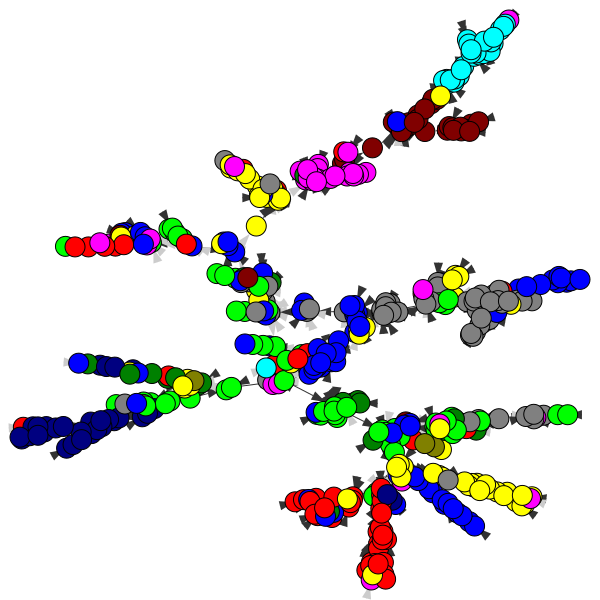

In [125]:
igraph.plot(sector_MST_g)